In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

## General classes

In [3]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [4]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

#### Environment

In [5]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Agent without inventory constraint - UCB1

In [6]:
class UCB1(Agent):
    def __init__(self, T, P, range=1):
        self.range = range # Range of the reward
        self.P = P # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)

            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

#### Clairvoyant without inventory constraint

In [7]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(
            c, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=(0, 1)
        )
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [8]:
# Parameters
T = 10000

# Prices
max_price = 1
price_step = T ** (-1/3)
prices = np.arange(0, max_price, price_step)
P = len(prices)

# Valuation prob. distribution
max_valuation = 1
#valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [9]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, P, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

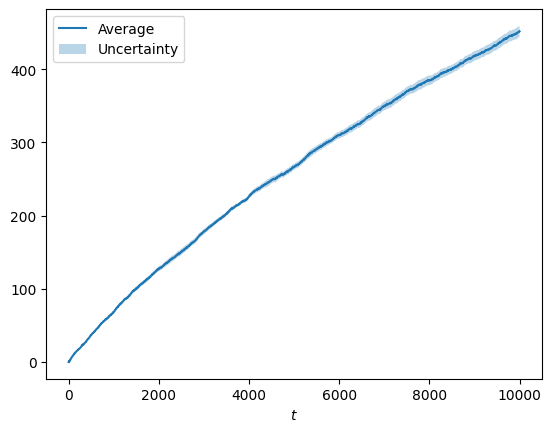

In [10]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

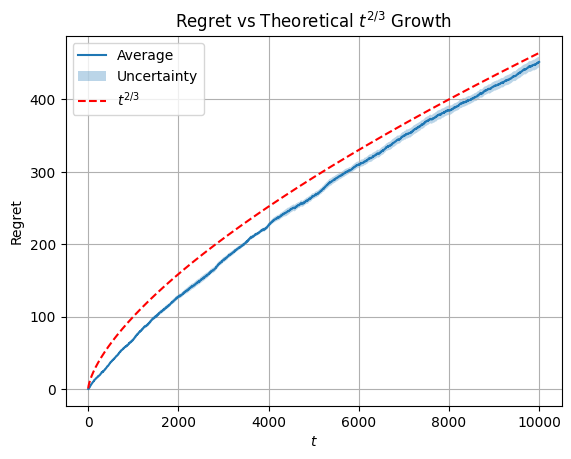

In [11]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = t**(2/3)

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_51681/658430586.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Regret vs Theoretical $\sqrt{K t \log t}$ Growth")


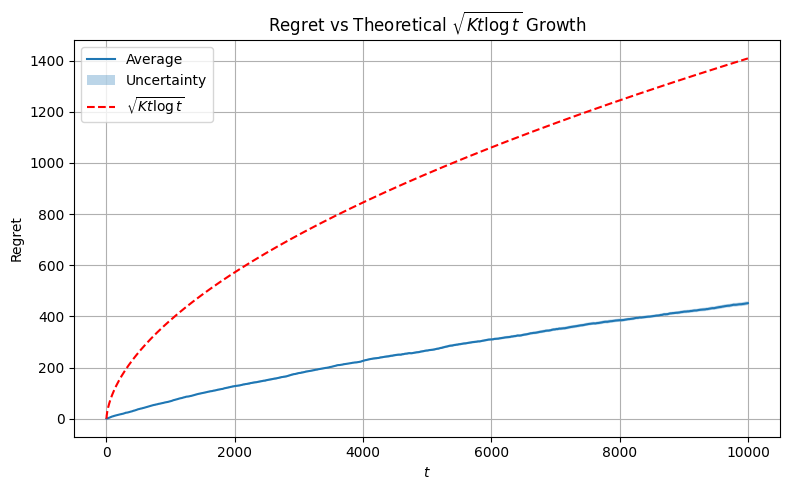

In [12]:
K= 1/price_step
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(K * t * np.log(t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)

# Aggiunta curva asintotica
plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{K t \log t}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{K t \log t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Agent with inventory constraint - UCB-like

In [13]:
class UCBLike():
    def __init__(self, T, B, P, range=1):
        self.T = T
        self.P = P
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = 0
            return 0

        if self.t < self.P:
            self.pi_t = self.t
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma

        c = -f_ucbs

        A_ub = [c_lcbs]
        rho = self.budget/self.T
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=(0,1)
        )

        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

#### Clairvoyant with inventory constraint

In [17]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, B, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices
        self.budget = B

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        # Per-round budget
        rho = selling_prob[-1] + 1

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob]
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(
            c, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            bounds=(0, 1)
        )
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [18]:
# Parameters
T = 10000
B = T * 45/100

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

# Valuation prob. distribution  
max_valuation = 1
valuation_distr = stats.uniform(loc=0, scale=max_price)

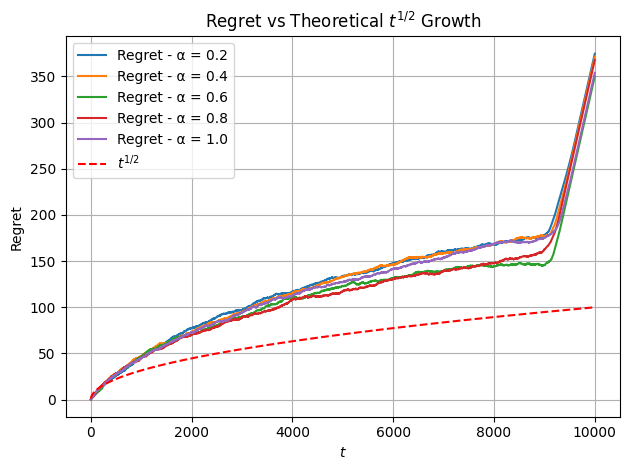

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticInventoryClaivoyant(T, B, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T)
  ucb_like_agent = UCBLike(T, B, P, range=max_price)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label=f'Regret')


t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = t**(1/2)
plt.plot(t - 1, theoretical_curve, label="${t}^{1/2}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical ${t}^{1/2}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Requirement 2: multiple products and stochastic environment

In [158]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, valuations_distr):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer
    # Valuation of each buyer sampled from the given distribution function
    self.valuations = []
    for distr in valuations_distr:
      self.valuations.append(distr.rvs(size=T))

    self.valuations = np.array(self.valuations).transpose()

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

#### Agent with invetory constraint: Combinatorial-UCB

In [550]:
class CombinatorialUCB():
    def __init__(self, T, B, P, N, range=1):
        self.T = T
        self.P = P
        self.N = N
        self.budget = B
        self.range = range

        self.avg_f = np.zeros((N, P))
        self.avg_c = np.zeros((N, P))
        self.N_pulls = np.zeros((N, P))

        self.pi_t = None

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = np.array([0  for _ in range(self.N)])
            return self.pi_t

        # Exploration: try each price vector at least once
        if self.t < self.P:
            self.pi_t = np.array([self.t for _ in range(self.N)])
        else:
            # Initialize f_ucb and c_ucb for each arm (matrix)
            f_ucbs = np.zeros(self.avg_f.shape, dtype=float)
            c_lcbs = np.zeros(self.avg_c.shape, dtype=float)

            # For each unexplored arm, set a large value of f_ucb and 0 c_ucb
            #large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
            large_value = 1e10
            unexplored = (self.N_pulls == 0)
            f_ucbs[unexplored] = large_value
            c_lcbs[unexplored] = 0

            # Get the mask of the arms that have been pulled at least one time
            # and then set the f_ucb and c_ucb for these arms
            mask = self.N_pulls > 0
            f_ucbs[mask] = self.avg_f[mask] + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls[mask])
            c_lcbs[mask] = self.avg_c[mask] - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls[mask])
            c_lcbs[c_lcbs < 0] = 0

            # Optimal distribution over superarms
            gamma = self.compute_opt(f_ucbs.reshape(-1), c_lcbs.reshape(-1))

            # Set current prices
            sampled_indices = []
            for i in range(self.N):
                sampled_indices.append(np.random.choice(self.P, p=gamma[i]))
            self.pi_t = sampled_indices
        
        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # Total variables
        tot_vars = self.N * self.P

        # Per-round budget
        rho = (self.budget / (self.T - self.t + 1)) + 1.5

        # Variables
        c = -f_ucbs

        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )
        
        if res.success:
            gamma = []
            solution = res.x
            var_index = 0
            for i in range(self.N): 
                gamma_i = solution[var_index : var_index + self.P]
                gamma_i = gamma_i / gamma_i.sum()  # Ensure normalization
                gamma_i = np.abs(gamma_i)
                gamma.append(gamma_i)
                var_index = var_index + self.P
            return gamma
        else:
            # Select UCB-maximizing price for each product
            return [np.eye(self.P)[np.argmax(f_ucbs[i])] for i in range(self.N)]

    def update(self, f_t, c_t):
        # Update the number of pulls of each arm in played superarm
        for i in range(self.N):
            self.N_pulls[i][self.pi_t[i]] += 1

            # Update empirical means
            self.avg_f[i][self.pi_t[i]] += (f_t[i] - self.avg_f[i][self.pi_t[i]])/self.N_pulls[i][self.pi_t[i]]
            self.avg_c[i][self.pi_t[i]] += (c_t[i] - self.avg_c[i][self.pi_t[i]])/self.N_pulls[i][self.pi_t[i]]

        # Update budget
        self.budget = self.budget - np.sum(c_t)

        self.t += 1

#### Clairvoyant with inventory constraint

In [551]:
class MultipleProductInventoryClairvoyant(Environment):
    def __init__(self, T, B, N, prices, valuations_distr):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.valuations_distr = valuations_distr

    def get_selling_probabilities(self):
        obj = [1 - distr.cdf(self.prices) for distr in self.valuations_distr]
        return np.array(obj)    

    def run(self):
        # Probability of selling of each price for each chosen distributions of product valuations
        selling_prob = self.get_selling_probabilities()

        # Per-round budget
        rho = np.sum(selling_prob[:, -1]) + 1

        # Number of variables
        tot_vars = self.N * self.P

        # Linear programming 
        c = -(selling_prob * self.prices).reshape(-1)

        A_ub = [selling_prob.reshape(-1)]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )

        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility


#### Evaluation

In [552]:
# Parameters
T = 10000
B = T * 60/100

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

# Valuation prob. distribution  
valuations_distr = [
    stats.norm(loc=0.5, scale=1),
    stats.beta(a=3, b=2),
    stats.beta(a=2, b=20),
]

N = len(valuations_distr)

In [557]:
# Run clairvoyant
clairvoyant = MultipleProductInventoryClairvoyant(T, B, N, prices, valuations_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 30
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductEnvironment(T, N, valuations_distr)
  combinatorial_ucb = CombinatorialUCB(T, B, P, N, range=max_price)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = combinatorial_ucb.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get rewardx
    r_t = env.round(p_t)

    # Update agent state
    combinatorial_ucb.update(r_t, r_t > 0.)

    agent_rewards.append(np.sum(r_t))

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

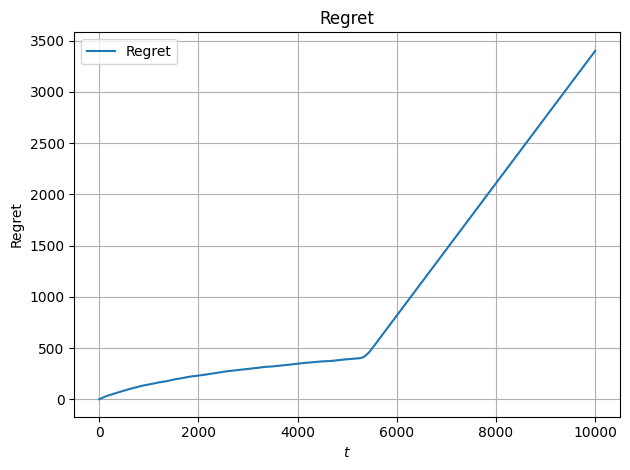

In [558]:
plt.plot(np.arange(T), average_regret, label=f'Regret')
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Requirement 3: best-of-both-worlds algorithms with a single product

### Requirement 4: best-of-both-worlds algorithms with multiple products

### Requirement 5: slightly non-stationary environments with multiple products

In [634]:
class MultipleProductSlightyNonStationaryEnvironment(Environment):
  def __init__(self, T, N, distributions, min_interval, max_interval):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    self.min_interval = min_interval
    self.max_interval = max_interval
    self.interval_lengths = []
    self.interval_distributions = []
    self.valuations = []
    
    self.distributions = np.array(distributions)

  def get_interval_distributions(self):
    return self.interval_distributions

  def get_interval_lengths(self):
    return self.interval_lengths

  def get_intervals(self):
    # Define an array of interval lengths among the time horizon
    interval_lengths = []
    while sum(interval_lengths) < self.T:
      length = np.random.randint(self.min_interval, self.max_interval + 1)
      interval_lengths.append(length)

    return interval_lengths

  def set_intervals_distributions(self, interval_lengths):
    # Define an array of distributions to use in each interval
    interval_distributions = []

    for _ in range(len(interval_lengths)):
      dist_i = np.random.choice(len(self.distributions), size=self.N)
      interval_distributions.append(self.distributions[dist_i])

    return interval_distributions

  def init_environment(self):
    # Setup environment
    self.interval_lengths = self.get_intervals()
    self.interval_distributions = self.set_intervals_distributions(self.interval_lengths)

    for length, distributions in zip(self.interval_lengths, self.interval_distributions):
      for _ in range(length):
        self.valuations.append([distr.rvs() for distr in distributions])

    self.valuations = np.array(self.valuations)

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1

    return reward

#### Agent with inventory constraint: Combinatorial-UCB with sliding window

In [763]:
class CombinatorialUCB_SW():
    def __init__(self, T, B, P, N, W, scale=1):
        self.T = T
        self.P = P
        self.N = N
        self.W = W
        self.budget = B
        self.scale = scale

        self.N_pulls = np.zeros((N, P))

        self.f_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)
        self.c_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)

        self.pi_t = None

        self.t = 0

    def pull_arm(self):
        if self.budget < 1:
            self.pi_t = np.array([0  for _ in range(self.N)])
            return self.pi_t

        # Exploration: try each price vector at least once
        if self.t < self.P:
            self.pi_t = np.array([self.t for _ in range(self.N)])
        else:
            # Initialize f_ucb and c_ucb for each arm (matrix)
            f_ucbs_last_W = np.zeros((self.N, self.P), dtype=float)
            c_lcbs_last_W = np.zeros((self.N, self.P), dtype=float)
            avg_f_last_W = np.zeros((self.N, self.P))
            avg_c_last_W = np.zeros((self.N, self.P))

            N_pulls_last_W = np.array(self.W - np.isnan(self.f_cache).sum(axis=0))

            # For each unexplored arm, set a large value of f_ucb and 0 c_ucb
            #large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
            large_value = 1e10
            unexplored = (N_pulls_last_W == 0)
            f_ucbs_last_W[unexplored] = large_value
            c_lcbs_last_W[unexplored] = 0

            # Get the mask of the arms that have been pulled at least one time
            # and then set the f_ucb and c_ucb for these arms
            mask = N_pulls_last_W > 0
            avg_f_last_W[mask] = np.nanmean(self.f_cache, axis=0)[mask]
            
            avg_c_last_W[mask] = np.nanmean(self.c_cache, axis=0)[mask]
            
            f_ucbs_last_W[mask] = avg_f_last_W[mask] + self.scale * np.sqrt(2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[mask] = avg_c_last_W[mask] - self.scale * np.sqrt( 2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[c_lcbs_last_W < 0] = 0

            # Optimal distribution over superarms
            gamma = self.compute_opt(f_ucbs_last_W.reshape(-1), c_lcbs_last_W.reshape(-1))

            # Set current prices
            sampled_indices = []
            for i in range(self.N):
                sampled_indices.append(np.random.choice(self.P, p=gamma[i]))
            self.pi_t = sampled_indices
        
        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # Total variables
        tot_vars = self.N * self.P

        # Per-round budget
        # rho = (self.budget / (self.T - self.t + 1)) - 0.5
        rho = (self.budget / self.T) + 2

        # Variables
        c = -f_ucbs

        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )

        if res.success:
            gamma = []
            solution = res.x
            var_index = 0
            for i in range(self.N): 
                gamma_i = solution[var_index : var_index + self.P]
                gamma_i = gamma_i / gamma_i.sum()  # Ensure normalization
                gamma_i = np.abs(gamma_i)
                gamma.append(gamma_i)
                var_index = var_index + self.P
            return gamma
        else:
            # Select UCB-maximizing price for each product
            return [np.eye(self.P)[np.argmax(f_ucbs[i])] for i in range(self.N)]

    def update(self, f_t, c_t):
        # Remove oldest observation
        self.f_cache = np.delete(self.f_cache, (0), axis=0)
        self.c_cache = np.delete(self.c_cache, (0), axis=0)

        f_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)
        c_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)

        # Update the number of pulls of each arm in played superarm
        for i in range(self.N):
            self.N_pulls[i][self.pi_t[i]] += 1

            f_new_samples[i][self.pi_t[i]] = f_t[i]            
            c_new_samples[i][self.pi_t[i]] = c_t[i]

        f_new_samples = np.expand_dims(f_new_samples, axis=0)
        c_new_samples = np.expand_dims(c_new_samples, axis=0)

        # Add new observation
        self.f_cache = np.vstack((self.f_cache, f_new_samples))
        self.c_cache = np.vstack((self.c_cache, c_new_samples))

        # Update budget
        self.budget = self.budget - np.sum(c_t)

        self.t += 1

#### Clairvoyant with inventory constraint

In [774]:
class MultipleProductSlighlyNonStationaryInventoryClairvoyant(Environment):
    def __init__(self, T, B, N, prices):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.interval_distributions = []
        self.interval_lengths = []

    def set_interval_lengths(self, interval_lengths):
        self.interval_lengths = interval_lengths

    def set_interval_distributions(self, interval_distributions):
        self.interval_distributions = interval_distributions
    
    def get_selling_probabilities(self, valuations_distr):
        obj = [1 - distr.cdf(self.prices) for distr in valuations_distr]
        return np.array(obj)   

    def run(self):
        # Number of variables
        tot_vars = self.N * self.P

        interval = 0
        expected_utilities = []
        for distr in self.interval_distributions:
            # Probability of selling
            selling_prob=self.get_selling_probabilities(distr)

            # Per-round budget
            rho = np.sum(selling_prob[:, -1]) + 1.5

            ## Linear programming
            c = -(selling_prob * self.prices).reshape(-1)

            A_ub = [selling_prob.reshape(-1)]
            b_ub = [rho]

            A_eq = []
            b_eq = []
            var_index = 0
            for i in range(self.N):
                eq_row = np.zeros(tot_vars)
                eq_row[var_index:var_index + self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)
                var_index = var_index + self.P

            res = optimize.linprog(
                c, 
                A_ub=A_ub, 
                b_ub=b_ub, 
                A_eq=A_eq, 
                b_eq=b_eq, 
                bounds=[(0, 1) for _ in range(tot_vars)]
            )

            for _ in range(self.interval_lengths[interval]):
                expected_utilities.append(-res.fun)
            interval = interval + 1
        return expected_utilities


In [1]:
# Parameters
T = 20000
B = T * 65/100
N = 3
W = 2*int(np.sqrt(T))
min_interval = 500
max_interval = 2000

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

distributions = [
    stats.norm(loc=0.5, scale=1),
    stats.norm(loc=0.5, scale=0.5),
    stats.norm(loc=0.5, scale=0.1),
    stats.beta(a=2, b=2),
    stats.beta(a=0.9, b=0.9),
    stats.beta(a=20, b=20)
]

NameError: name 'np' is not defined

In [865]:
# Run clairvoyant
clairvoyant = MultipleProductSlighlyNonStationaryInventoryClairvoyant(T, B, N, prices)

n_trials = 5
regret_per_trial = []
budget_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductSlightyNonStationaryEnvironment(T, N, distributions, min_interval, max_interval)
  env.init_environment()

  clairvoyant.set_interval_distributions(env.get_interval_distributions())
  clairvoyant.set_interval_lengths(env.get_interval_lengths())
  expected_clairvoyant_utilities = clairvoyant.run()[:T]

  combinatorial_ucb_sw = CombinatorialUCB_SW(T, B, P, N, W, scale=max_price)

  agent_rewards = []
  budget = []
  for t in range(T):
    # This returns the price index
    pi_t = combinatorial_ucb_sw.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get rewardx
    r_t = env.round(p_t)

    # Update agent state
    combinatorial_ucb_sw.update(r_t, r_t > 0.)

    agent_rewards.append(np.sum(r_t))
    budget.append(combinatorial_ucb_sw.budget)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

regret_per_trial = np.array(regret_per_trial)
budget_per_trial = np.array(budget_per_trial)

average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation
average_budget = budget_per_trial.mean(axis=0)

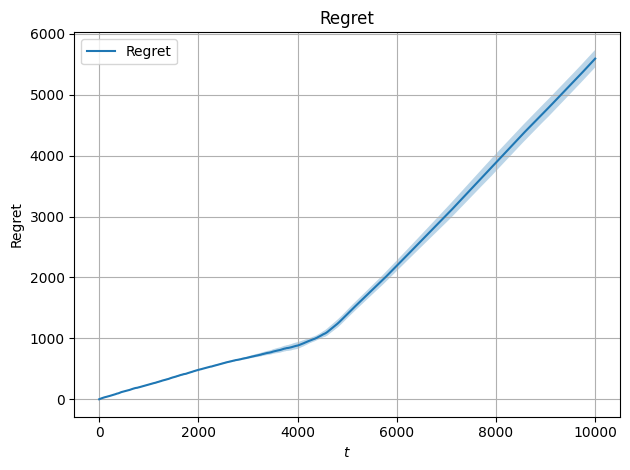

In [ ]:
plt.plot(np.arange(T), average_regret, label=f'Regret')
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()